# Kaggle Grasp Lift Model Development

Here is a summary of the steps that I went through to get comparable performance to the best single models on the kaggle set. The best single model, according to the authors of the second model, had 0.97652/0.97661 mean auc on the public/private leaderboard. My goal was to reach atleast 0.96 on both leaderboards to be in a somewhat similar range.





## Raw Net

The first step was applying our rawnet on the data. I tried out :

* pool strides 10 and pool length 50 or pool stride 20 and pool length 100 and pool lengths
* oversampling turned on and off 
* different factors for reweighting the loss.



In [4]:
import numpy as np

from braindecode.scripts.print_results import ResultPrinter

I show the results sorted by mean test auc.
The nets used an input window of 608 samples, the signal was downsampled to 250 Hz. 
So we used roughly 2.4 seconds to predict a sample.

We can see:

* the smaller pool stride and pool length is better
* oversampling does not affect the results much
* a reweighting/imbalance factor of around 20 to 40 gave the best results

Models from ```data/models/grasp-lift/4-sec/```

|id|oversample|pool_stride|pool_len|imba_factor|time|std|test|std|train|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|4|True|10|50|20|0:25:10|0:08:44|91.47%|3.42%|98.85%|0.42%|98.19%|0.55%|
|11|False|10|50|20|0:24:16|0:08:38|91.28%|3.19%|98.79%|0.55%|97.77%|1.03%|
|0|True|10|50|40|0:27:31|0:14:39|91.28%|3.20%|98.67%|0.66%|97.87%|1.02%|
|13|False|10|50|40|0:25:53|0:10:06|91.09%|3.33%|98.67%|0.69%|97.64%|0.89%|
|15|False|10|50|80|0:25:06|0:10:19|91.01%|3.48%|98.50%|0.69%|97.36%|1.13%|
|9|False|10|50|10|0:20:25|0:05:20|90.95%|4.12%|98.58%|1.02%|97.71%|1.24%|
|7|True|10|50|80|0:31:27|0:09:22|90.71%|3.84%|98.84%|0.39%|98.05%|0.70%|
|2|True|10|50|10|0:32:27|0:27:07|90.66%|3.57%|98.93%|0.53%|98.34%|0.71%|
|3|True|20|100|10|1:00:55|0:31:43|90.47%|2.85%|98.10%|1.09%|95.77%|1.28%|
|16|False|20|100|80|0:52:38|0:18:49|90.37%|2.46%|98.13%|0.35%|95.34%|0.63%|
|14|False|20|100|40|0:53:41|0:22:09|90.30%|2.47%|97.78%|1.12%|94.98%|1.58%|
|10|False|20|100|10|0:50:47|0:23:11|90.25%|2.60%|98.10%|0.92%|95.57%|0.87%|
|5|True|20|100|20|0:48:39|0:20:23|90.16%|3.02%|98.03%|0.51%|95.56%|0.82%|
|12|False|20|100|20|0:53:58|0:33:20|90.13%|3.33%|98.23%|0.53%|95.60%|0.90%|
|8|True|20|100|80|0:53:26|0:23:17|89.92%|3.05%|97.59%|0.75%|95.08%|1.04%|
|6|True|20|100|40|0:55:05|0:34:06|89.70%|3.56%|97.78%|0.79%|95.29%|1.03%|


Next, I tried to verify that my test AUCs match the kaggle metric by retraining the best model on all data and submitting on the kaggle site.

I reached a performance of 

    0.92357 	0.91203 	
    
On public and private leaderboard, so a little better than my own numbers, which is plausible since we use more data for the training now.



## Deeper Model

Now with a working model still more than 5% worse than the best single model, we discussed to try deeper networks. I build a network with 6 layers.

The network had the same separated time-space-convolution at the start as the rawnet, and then continued with pooling + convolution + pooling etc. I fixed:

* filter length 30 for all layers
* pool length 3, pool stride 2
* input length was 1025 samples, so about 4 seconds with 250 Hz data
* number of filters 40 per layer

I tried:

* Max Pooling, Mean Pooling or Sum Pooling
* Squared Nonlinearity + Log after pooling or leaky relu nonlinearity

I also tried different values of these for the first and the later layers.

We see that leaky relu and max pooling consistently yield better results than squaring and log. Max pooling seems slightly better but the results are not so clear here. One weird thing: The first 6 results all have a "Sum" Pooling layer in the first or later layers, even when all pooling modes are max pooling. In this case, the output of the max pooling will be multiplied with the size of the pool region. Maybe this is just random, the first result with "normal" max pooling, id 12, is just 1% worse.

We also see that the best model is still about 5% worse than the best single model.

Models from ```data/models/grasp-lift/deeper/```

|id|p_l|1st_p_l|late_p_nonlin|late_nonlin|1st_p_mode|1st_p_nonlin|1st_nonlin|p_mode|time|std|test|std|train|std|valid|std|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|18|Sum|Pool|identity|leaky_relu|max|identity|leaky_relu|max|0:51:16|0:11:45|92.68%|2.45%|98.48%|0.90%|96.59%|1.92%|
|22|Pool|Sum|identity|leaky_relu|max|identity|leaky_relu|max|0:38:14|0:10:51|92.64%|2.11%|97.63%|2.24%|96.66%|1.76%|
|23|Pool|Sum|identity|leaky_relu|max|identity|leaky_relu|mean|0:44:29|0:07:10|92.48%|2.42%|99.18%|0.09%|97.56%|0.66%|
|21|Sum|Pool|identity|leaky_relu|mean|identity|leaky_relu|mean|0:49:37|0:27:11|92.02%|2.74%|97.76%|1.27%|96.82%|0.95%|
|9|Pool|Sum|identity|leaky_relu|mean|identity|leaky_relu|max|0:34:05|0:06:21|91.96%|2.34%|97.01%|2.66%|96.15%|1.96%|
|17|Sum|Sum|identity|leaky_relu|mean|identity|leaky_relu|mean|0:41:51|0:07:22|91.86%|3.05%|98.55%|0.24%|96.84%|0.92%|
|12|Pool|Pool|identity|leaky_relu|max|identity|leaky_relu|mean|0:40:42|0:16:38|91.86%|2.52%|98.00%|0.93%|96.51%|0.82%|
|13|Pool|Pool|identity|leaky_relu|mean|identity|leaky_relu|max|0:32:55|0:03:04|91.63%|2.89%|98.56%|0.64%|97.04%|0.89%|
|10|Pool|Sum|identity|leaky_relu|mean|identity|leaky_relu|mean|0:44:28|0:11:07|91.47%|4.17%|98.37%|1.45%|97.32%|1.29%|
|11|Pool|Pool|identity|leaky_relu|max|identity|leaky_relu|max|0:33:22|0:09:53|90.65%|2.94%|97.12%|2.18%|96.29%|1.55%|
|14|Pool|Pool|identity|leaky_relu|mean|identity|leaky_relu|mean|0:40:56|0:11:14|89.88%|5.62%|98.48%|0.90%|97.09%|0.90%|
|20|Sum|Pool|identity|leaky_relu|mean|identity|leaky_relu|max|1:15:13|0:31:54|89.72%|5.09%|99.01%|0.24%|97.58%|0.93%|
|1|Pool|Sum|identity|leaky_relu|mean|safe_log|square|mean|0:31:45|0:07:03|89.61%|4.97%|97.18%|1.33%|95.58%|1.78%|
|15|Sum|Sum|identity|leaky_relu|max|identity|leaky_relu|mean|0:52:12|0:01:29|89.53%|3.21%|98.73%|0.58%|97.37%|0.19%|
|8|Sum|Sum|identity|leaky_relu|max|identity|leaky_relu|max|0:58:10|0:32:18|89.10%|2.90%|95.80%|2.78%|95.71%|1.62%|
|4|Pool|Pool|identity|leaky_relu|mean|safe_log|square|max|0:42:32|0:05:20|88.58%|4.97%|98.75%|0.41%|97.15%|0.63%|
|16|Sum|Sum|identity|leaky_relu|mean|identity|leaky_relu|max|1:14:52|0:43:48|88.01%|5.45%|98.08%|0.29%|96.79%|0.36%|
|0|Pool|Sum|identity|leaky_relu|mean|safe_log|square|max|0:40:29|0:07:30|86.54%|5.29%|98.75%|0.54%|97.29%|1.09%|
|5|Pool|Pool|identity|leaky_relu|mean|safe_log|square|mean|0:32:30|0:02:58|85.15%|8.83%|98.11%|1.31%|96.67%|1.38%|
|19|Sum|Pool|identity|leaky_relu|max|identity|leaky_relu|mean|1:00:34|0:23:35|84.36%|7.26%|91.62%|9.29%|91.29%|7.54%|
|3|Pool|Sum|safe_log|square|mean|safe_log|square|mean|0:48:34|0:16:44|79.12%|7.21%|94.62%|3.64%|92.74%|3.96%|
|6|Sum|Pool|safe_log|square|mean|safe_log|square|mean|1:13:41|0:56:23|79.06%|9.45%|91.69%|6.09%|90.25%|5.12%|
|7|Pool|Pool|safe_log|square|mean|safe_log|square|mean|1:25:48|0:42:49|79.00%|9.98%|91.12%|10.03%|92.33%|5.10%|
|2|Sum|Sum|safe_log|square|mean|safe_log|square|mean|0:58:08|0:38:24|76.77%|9.97%|84.87%|10.06%|86.00%|7.25%|

## Training on All Subjects

I dug a little bit deeper into the code of the second place finisher to look for reasons for the gap. There were atleast four things. 
1. They use about 7 seconds of the data as input. 
2. They seem to train the model on all subjects and evaluate on all subjects. 
3. They did not do any resampling. There is a reason to expect our resampling to have some negative effects on the results: The resampling to half the sampling rate not only reduces the number of samples to half but also "loses" a sample, probably at the end. To ensure a fair comparison (i.e., that we are definitely not using any future data), I removed the first target. In case the sample is actually lost at the end, this means we are having to predict one sample earlier. 
4. They use larger pool strides and length (4).
5. They use much more filters per layer (256 instead of 40)

I first tried the same model as before, but training on all subjects and varying the number of filters. This was the result:

Models from ```data/models/grasp-lift/all-sub/deeper/```

|id|num_filters|time|test|best|epoch|train|valid|
|-|-|-|-|-|-|-|-|
|1|40|7:54:44|93.70%|94.96%|116|97.76%|97.34%|
|2|80|3:05:37|63.11%|87.27%| 10|66.04%|66.36%|
|3|120|4:58:46|49.99%|76.59%| 12|49.87%|50.74%|

## Balancing Batch Sizes

We see see some strong instability in the training, note the difference between test and best value.
Also, look at the plot of the loss values below for experiment 2 (x-axis are epochs).
After epoch 10 there is a weird peak, even in the training loss. Also note the low number of epochs suggesting that before the early stop, the training was also instable leading to the selection of a very early model after the stop. I discovered one possible reason: It could happen that I make updates on batches with arbitrarily small sizes, even size one (which would mean adam makes an update on only a single timeblock).

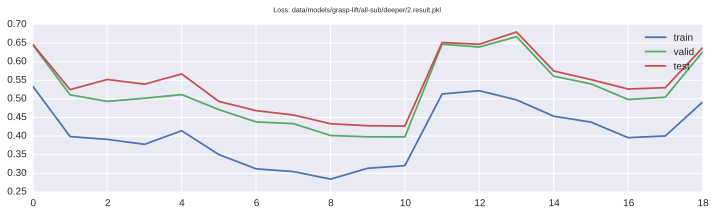

In [88]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

import matplotlib.lines as mlines
import seaborn
matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)
matplotlib.rcParams['font.size'] = 7
seaborn.set_style('darkgrid')
from braindecode.analysis.plot_util import plot_loss_for_file
_ = plot_loss_for_file('data/models/grasp-lift/all-sub/deeper/2.result.pkl')

I changed this again so that all batches have the same size +-1. 

After fixing this, I reran with 40 filters and got ```95.35``` test AUC (```data/models/grasp-lift/all-sub/deeper/4.pkl```).

I then tried to make the model even more similar to theirs, using

* pool stride/length 3
* no resampling
* 3751 input samples, i.e. about 7.5 seconds

This led to a result of ```95.23``` (```data/models/grasp-lift/all-sub/more-time/no-resample/deeper/11.pkl```). I did consider that result to be better because the ```95.35``` result was stopping at exactly the epoch with the best result so far, so I considered it a bit lucky.

## Input padding

I submitted this model's predictions to kaggle and got ```0.94344 0.94532```(public/private). The difference to my own result is quite large now. The reason seems that I lose too many samples at the start of each test series: Since I use an input length of 7.5 seconds, the first sample I can predict is after 7.5 seconds. Before, I just predict zero. We can check how many target labels we lose for that part, e.g., for subject 1.



In [64]:
from braindecode.datasets.grasp_lift import KaggleGraspLiftSet

In [89]:
kaggle_set = KaggleGraspLiftSet(data_folder='data/kaggle-grasp-lift/', i_subject=1, resample_half=False)

kaggle_set.load()
lost_targets = sum([np.sum(kaggle_set.train_y_series[i_series][:3751]) for i_series in range(8)])
all_targets = sum([np.sum(kaggle_set.train_y_series[i_series]) for i_series in range(8)])
print("Lost targets {:.2}%".format(100 * lost_targets / float(all_targets)))

Lost targets 3.0%


I tried different input paddings to overcome this problem, checking that the predictions for the input padding itself are all small (there are no targets right at the start of the series). It seemed to work best to prepend 3751 samples from the end of the series to get good predictions.

After doing this I got ```0.96022 0.96213``` (public/private).

## Further possible improvements for deep model

There is still a gap of ~1.5% to the best single model and there are some improvements to consider:

* different filter time lengths (shorter)
* batch normalization (second place uses this after each convolutional layer)
* different pool length/strides (we use 3, second place uses 4)
* very leaky relu instead of leaky relu (again, like second place)
* same convolutions (i.e. with padding so that output remains same) instead of valid convolutions
* different preprocessings

Regarding the preprocessings, the second place uses only one preprocessing. For each input window, they subtract the mean for each channel (they do this online). So they don't seem to even bring the values into a standardized range, however they use batch normalization later.
In my current network architecture, doing several predictions at once, I cannot do this preprocessing, however I can remove a baseline before a block of predicted samples. 

I already tried combinations of:

* removing the baseline as described
* online standardization, i.e. standardizing the train set (after concatenating all series) "normally" by means and standard deviations, and then recomputing means and standard deviations for each sample for the valid/test set
* exponentially moving standardization of each of the 8 series per subject (i.e. computing standard deviations and means for each sample similar to https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average). I did this because the different series actually seem to have different means and deviations for the channels.

Surprisingly online preprocessing + removing baseline seems to work better than exponentially moving standardization of each series... However, I only tried one decay factor for the moving standardization (0.99), maybe others would be better.
For the submission above I actually used preproc_series => exponentially moving standardization and *no* removal of the baseline.

Models from ```data/models/grasp-lift/all-sub/more-time/no-resample/deeper/```

|id|final_len|#batch|preproc|preproc_series|input_len|rm_base|p_len|time|test|best|epoch|train|valid|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|22|25|64|online_c_1|False|3000|True|3|15:03:09|94.74%|95.16%|133|98.48%|97.92%|
|15|25|32|online_c_1|False|5000|True|3|6:50:49|94.46%|94.67%| 88|98.09%|97.51%|
|14|25|32|online_c_1|False|3000|True|3|6:18:21|94.05%|94.44%| 39|97.34%|96.99%|
|5|25|32|online_c_1|False|5000|True|3|4:40:07|93.93%|94.36%| 49|97.87%|97.14%|
|8|25|32|null|True|5000|False|3|5:40:32|93.75%|94.67%| 61|98.20%|98.03%|
|10|25|32|online_c_1|False|3000|True|3|7:43:02|93.73%|94.79%| 45|97.65%|97.06%|
|3|5|32|online_c_1|False|5000|True|3|6:30:57|93.52%|93.66%| 73|97.78%|97.41%|
|6|5|32|null|True|5000|False|3|6:15:47|93.35%|93.46%| 59|98.17%|98.15%|
|7|5|32|online_c_1|False|5000|False|3|4:10:45|93.07%|93.07%| 61|97.41%|97.39%|
|9|25|32|online_c_1|False|5000|False|3|5:48:16|92.57%|93.03%| 69|97.86%|97.66%|
|2|5|32|null|True|5000|True|3|5:12:22|92.07%|93.44%| 61|98.01%|97.25%|
|4|25|32|null|True|5000|True|3|5:01:37|91.45%|93.73%| 37|96.80%|96.50%|
|1|80|20|online_c_1|-|5000|-|4|5:27:20|75.86%|89.60%| 13|73.09%|77.46%|
|16|25|32|null|False|3000|True|3|4:47:07|74.96%|89.46%| 21|75.29%|76.70%|
|19|25|32|null|False|5000|True|3|6:59:08|68.76%|92.18%| 56|72.61%|70.58%|
|24|25|64|null|False|3000|True|3|7:26:25|61.39%|93.53%| 50|62.97%|62.96%|

At the moment, I don't consider improving the performance more by changes like this very important and will rather focus on visualizations plus possibly retrying simpler, less deep, models.

In [2]:
%%capture
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2